In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re

from structure_tools.Modules_tools import return_fsts

PCA_color_ref= ['darkseagreen','crimson', 'darkorange', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink']

### .vcf analysis

Jupyter notebook for the local analysis of genetic data stored in `.vcf` format.

Perform analysis of structure across data set, followed by a more detailed study of variation across local genomic windows.

### Input

In [2]:
from structure_tools.vcf_geno_tools import read_geno_nanum

filename= 'Filtered_Chr8_miss0.01.vcf'

row_info= 6
header_info= 9
phased= False

genotype, summary, Names= read_geno_nanum(filename, row_info= row_info, header_info= header_info,phased= phased)

print('Number of markers: {}'.format(genotype.shape[1]))
print('Number of individuals: {}'.format(genotype.shape[0]))


{'fileformat': 'VCFv4.2', 'fileDate': '20190322', 'source': 'PLINKv1.90', 'contig': '<ID8,length28428625>', 'INFO': '<IDPR,Number0,TypeFlag,Description"Provisional reference allele, may not be based on real reference genome">', 'FORMAT': '<IDGT,Number1,TypeString,Description"Genotype">'}
Number of markers: 15000
Number of individuals: 3023


In [3]:

## Instace specific processing due to ID copy in VCF file.

for x in range(len(Names)):
    ind= Names[x]
    newid= ind.split('_')
    if len(newid) > 2:
        newid= '_'.join(newid[:2])
    else:
        newid= newid[0]
    
    Names[x]= newid



In [4]:
Input_file= '3K_info.txt'

RG_info= pd.read_csv('3K_info.txt',sep= '\t')

RG_info.head(20)

IRIS_ID                 NAME    Variety_Name_verif       COUNTRY REGION  \
0     B001              HEIBIAO               Heibiao         China    As6   
1     B002            SANSUIJIN             Sansuijin         China    As6   
2     B003          ZAOSHENGBAI         Zaoshengbai_         China    As6   
3     B004   QIUGUANGTENGXI_104   Qiuguangtengxi_104_         Japan    As7   
4     B005               WANSHI                Wanshi         Japan    As7   
5     B006               YIKONG                Yikong       Vietnam    As4   
6     B007           TIANHANDAO            Tianhandao       Vietnam    As4   
7     B008              BAXIANG              Baxiang_       Vietnam    As4   
8     B009       VIETNAM_ZAODAO        Vietnam_Zaodao       Vietnam    As4   
9     B010            MALAIHONG            Malaihong_      Malaysia    As4   
10    B011                CO_22                 CO_22         India   As2a   
11    B012     2037(RAJAHAMSAL)      2037(Rajahamsal)         India   As2a   
12    B013          SRI_LANKA_1          Sri_Lanka_1_      Srilanka    As2   
13    B014        WUZILUOSI_215         Wuziluosi_215   SovietUnion     Eu   
14    B015               KAHAMU                Kahamu       Romania     Eu   
15    B016         AOMIERTE_168          Aomierte_168       Hungary     Eu   
16    B017             AERJITUO              Aerjituo      Bulgaria     Eu   
17    B018  AMERICAN_HUANGKEDAO  American_Huangkedao_  UnitedStates     Am   
18    B019         BULEIDA_A-75          Buleida_A-75        Mexico     Am   
19    B020           JINEIYADAO           Jineiyadao_        Guinea    Af1   

   K9_cluster Initial_subpop  
0      GJ-tmp           temp  
1      GJ-tmp           temp  
2      GJ-adm           japx  
3      GJ-tmp           temp  
4      GJ-tmp           temp  
5      XI-adm           indx  
6      XI-adm           indx  
7      GJ-tmp           temp  
8       XI-1A          ind1A  
9       XI-1A          ind1A  
10     XI-adm           indx  
11       XI-2           ind2  
12     XI-adm           indx  
13     GJ-tmp           temp  
14      XI-1A          ind1A  
15     GJ-tmp           temp  
16     GJ-tmp           temp  
17     GJ-trp           trop  
18     XI-adm           indx  
19      admix          admix

### Global variation

Perform PCA across data set.

Perform Mean shift clustering to attempt to extract genetically coherent groups of accessions.

These will later be used for supervised analysis.

In [5]:
Sn= 650
Sm= 13000

ID_col= 'IRIS_ID'
subset_col= 'Initial_subpop'

code= {
    'ind1A':0,
    'ind1B':0,
    'ind2':0,
    'ind3':0,
    'aus':1,
    'temp':2,
    'trop':2,
    'subtrop':2,
    'aro': 3,
    'admx': 4
}


others= 'admx'

### Subset to acceptable range of accessions x markers.

Present= [x for x in range(len(Names)) if Names[x] in list(RG_info[ID_col])]

if len(Present) < genotype.shape[0]:
    '{} IDs missing'.format(genotype.shape[0] - len(Present))

Nsample= sorted(np.random.choice(Present,Sn,replace= False))
Msample= sorted(np.random.choice(list(range(genotype.shape[1])),Sm,replace= False))

###
gen_sample= np.array(genotype[Nsample,:])

gen_sample= np.array(gen_sample[:,Msample])

subsummary= summary.loc[Msample,:]

subsummary= subsummary.reset_index()

Names_select= [Names[x] for x in Nsample]

###

print('{}, {}'.format(len(Msample),len(Nsample)))

print(gen_sample.shape)

###

Name_idx= [list(RG_info[ID_col]).index(x) for x in Names_select]
code_vec= [RG_info[subset_col][x] for x in Name_idx]

#code_vec= [code_vector[x] for x in Nsample]
code_vec= [[x,others][int(x not in code.keys())] for x in code_vec]

code_vec= [code[x] for x in code_vec]

code_lib= {
    z:[x for x in range(len(code_vec)) if code_vec[x] == z] for z in list(set(code_vec))
}

color_groups= ['red','yellow','blue','green','purple','black','silver','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']



13000, 650
(650, 13000)


In [6]:
## Perform PCA
n_comp= 5
pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')

feats= pca.fit_transform(gen_sample)

In [137]:
## perform MeanShift clustering.
bandwidth = estimate_bandwidth(feats, quantile=0.15)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True, min_bin_freq=15)
ms.fit(feats)
labels1 = ms.labels_
label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1)))}


In [138]:
###
from structure_tools.Tutorial_subplots import plot_global_classes


plot_global_classes(feats,
                    code_lib,
                    label_select,
                    color_groups,
                    PCA_color_ref,
                    title_I= 'IRRI class',
                    title_II= 'Mean_shift',height= 900, width= 950)


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



### Local Analysis

Analyse genetic variation across genomic windows. Begin by chosing the size of each window (`window_size`) and the distance between windows (in number of markers, `Steps`).

In [139]:
ref_dict= label_select
ref_vector= labels1

In [140]:
from structure_tools.vcf_geno_tools import geno_window_split
##### 
window_size= 121
Steps= 13

Windows, Out= geno_window_split(gen_sample,
                                subsummary,
                                Steps= Steps,
                                window_size=window_size)

print('number of chromosomes: {}'.format(len(Windows)))
print('number of windows: {}'.format(sum([len(Windows[x].keys()) for x in Windows.keys()])))


number of chromosomes: 1
number of windows: 992


### I. Local variation sample

Visualize genetic structure at local windows using PCA. Plot colors will correspond to the Mean shift clustering above. 

Use the list `plot_who` to plot only accessions from specific groups.

Use the list `shade` to lower the opacity of samples from specific groups.

In [12]:
## a look at local windows
from structure_tools.Tutorial_subplots import window_sample_plot

windows_pick= 5
Chr= 8

plot_who= [0,1,2,3]
shade= []


window_sample_plot(Windows,
                   ref_dict,
                   color_groups,
                   plot_who= plot_who,
                   shade= shade,
                   Chr= Chr,
                   windows_pick= windows_pick,
                   height= 1500,width= 1000)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]  
[ (2,1) x3,y3 ]    [ (2,2) x4,y4 ]  
[ (3,1) x5,y5 ]    [ (3,2) x6,y6 ]  
[ (4,1) x7,y7 ]    [ (4,2) x8,y8 ]  
[ (5,1) x9,y9 ]    [ (5,2) x10,y10 ]



### II. Variation across windows.

>*i. Chose a range of windows, or a number of windows to be sampled randomly.*

>*ii. Perform PCA, AMOVA and allele frequency extraction at each window*

Analyses can be performed in either a supervised or an unsupervised manner.
For supervised analyses, use the labels from the Meanshift analysis above to chose reference labels. If the argument `include_who` is provided (list), analyses will be perform using only samples from the groups identified in that list.

>*ii. Analyse genetic distance between reference or unsupervised groups at selected windows.*

>*iii. Analyze principal component analysis projection along 1st PC across windows selected.*


- **i.** Window analysis

In [141]:
from structure_tools.Modules_tools import return_fsts2
from structure_tools.vcf_geno_tools import window_analysis, window_fst_sup

ref_labels= [0,2,4]

fst_range= [0,len(Windows[8])]

Fst_window= window_fst_sup(Windows,
                         ref_labels,
                         ref_vector,
                         Chr= Chr,
                         ncomp= 4,
                        range_sample= fst_range)

D:\GitHub\Extract\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars



In [69]:

include_who= [0,2]
pc_range= [400,600]

Frequencies, sim_fst, Results, Construct, pc_density, pc_coords, fst_fig= window_analysis(Windows,
                                                                                 ref_labels,
                                                                                 ref_vector,
                                                                                 Chr= 8,
                                                                                 ncomp= 4,
                                                                                 amova= True,
                                                                                 supervised= True,
                                                                                 include_who= include_who,
                                                                                 range_sample= pc_range,
                                                                                 rand_sample= 0,
                                                                                 clsize= 15,
                                                                                 cl_freqs= 5,
                                                                                 Bandwidth_split= 20)



counting: 0.005243291253647708, Ngps: 2


In [70]:
Results['info'].head()

chrom      window     AMOVA  Ngps
0    8.0  13053574.0 -0.009465   2.0
1    8.0  13062603.0 -0.009472   2.0
2    8.0  13078004.0 -0.004551   2.0
3    8.0  13362106.0 -0.004696   2.0
4    8.0  13384377.0 -0.005223   2.0

- **ii.** Fst across data sets

In [71]:
iplot(fst_fig)

In [72]:
from scipy import stats
print('fst mean: {}, sd: {}'.format(*[round(x,3) for x in [np.mean(sim_fst),np.std(sim_fst)]]))

stats.norm.interval(0.95, loc=np.mean(sim_fst), scale=np.std(sim_fst))

fst mean: 0.025, sd: 0.008


(0.0092867608392509723, 0.041026787340952942)

In [142]:
from structure_tools.Tutorial_subplots import fst_window_plot


fst_window_plot(Fst_window,ref_labels,sort= False,window_range= fst_range)

- **iii.** PC sample distribution across data sets queried.

In [74]:
from structure_tools.Tutorial_subplots import PC_analysis_plot

labels_code= ref_vector
if include_who:
    labels_code= [x for x in labels_code if x in include_who]


#PC_analysis_plot(pc_density,pc_coords,[x +1 for x in labels_code],color_groups,range_windows= pc_range,plot_choice= 'coords')

### Supervised classification across windows.

Perform supervised classification of samples across local genomic windows using Kernel Density Estimation.

The function `KDE_windows` allows for an outlier threshold and a *p*-value comparison threshold for ambiguous classifications.

In [81]:
### KDE analysis across windows
from structure_tools.Sim_ideogram_tools import Merge_class, extract_profiles, KDE_windows, KDE_window_profiles, return_ideogram

## Use result of MS classification.
ref_labels= [0,1,2]
kde_class_labels= ref_vector
n_comps= 4
from IPython.display import clear_output

Windows_profiles, var_comp_store= KDE_window_profiles(Windows,ref_vector,ref_labels,n_comps= n_comps)

In [60]:
print(len(var_comp_store))

1074


In [134]:
from structure_tools.Sim_ideogram_tools import compress_ideo, class_and_ideo


Comparison_threshold= 4
Outlier_threshold= 1e-5

colors= 'standard'
alt_col= PCA_color_ref

groups_plot= [0,1,2]

ideo_kde, chromosome_list = class_and_ideo(Windows_profiles,Out,ref_vector,
                         Comparison_threshold= Comparison_threshold,
                         Outlier_threshold= Outlier_threshold,
                         groups_plot=groups_plot,
                         colors= 'standard',
                         alt_col= alt_col)


adding ideograms...


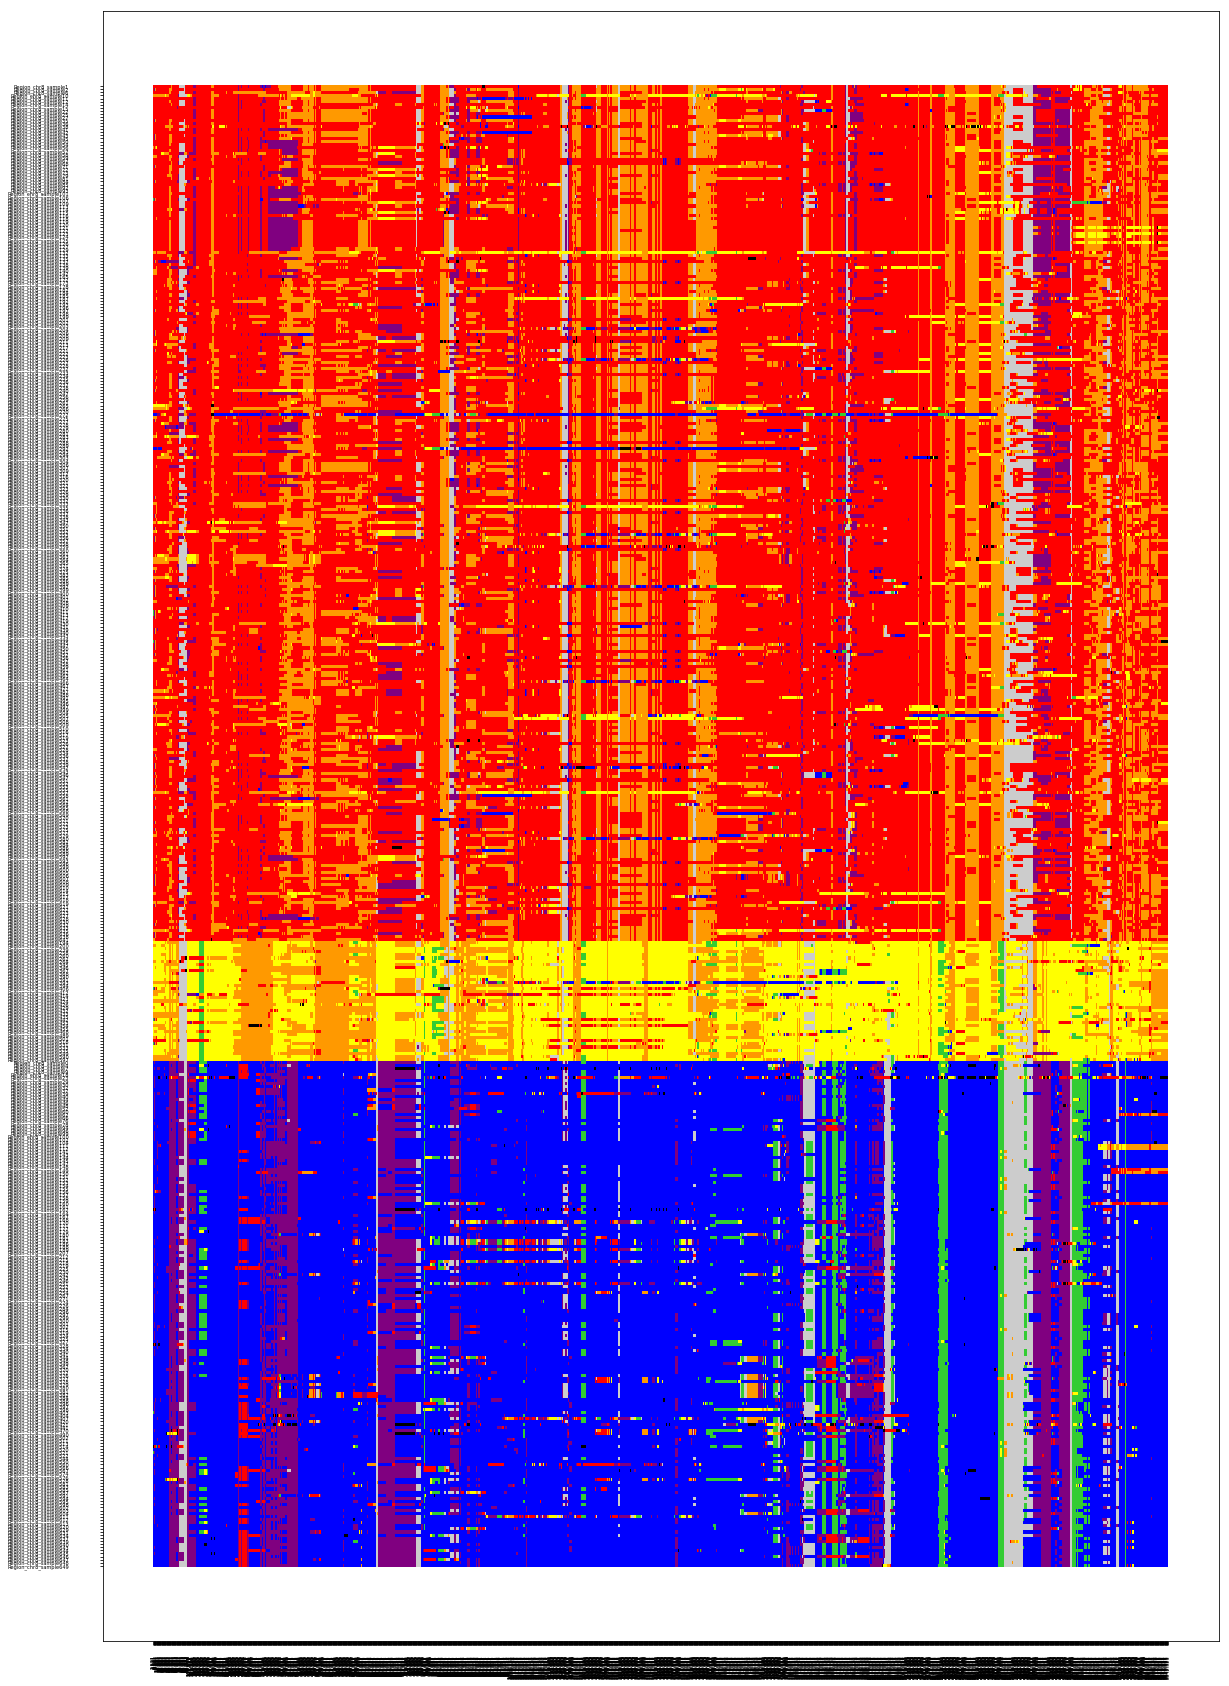

In [136]:
ID= 'kde_gp{}_w{}_N{}_M{}_th{}'.format('-'.join([str(x) for x in groups_plot]),Sn,Sm,window_size,Comparison_threshold)  


Fig_ideo= return_ideogram(ideo_kde,chromosome_list,ID,height= 30,width= 20)


### MeanShift cluster analysis

Parse and visualize local patterns of structure. 

We tackle the problem of identifying and comparing data structure across a great number of data sets. 

In [85]:
from structure_tools.StructE_tools import findPhiPT, Structure_profiles, Distance_profiles

from structure_tools.AMOVA_func import amova_cofactor, AMOVA_FM42
from structure_tools.mstutorial_tools import Windows_KDE_amova

### Perform Distance and association analysis on the data sets generated

### Define reference and admixed associations:
### for the purpose of this analysis exploration will be driven by
### structure distance profiles. Since KDE will be used for exploration, 
### a set of accessions can be analysed that do not contribute to 
### distance profiles.


##
ref_labels= [0,1,2]

refs_lib= {
    z: ref_dict[z] for z in ref_labels
}

KDE_comps= 4
clsize= 15
Bandwidth_split= 20

Results, Construct, PC_var= Windows_KDE_amova(Windows,
                                              ref_dict,
                                              refs_lib,
                                              supervised= True,
                                              amova= True,
                                              ncomps= KDE_comps,
                                              clsize= clsize,
                                              Bandwidth_split= Bandwidth_split)

chr 8, where: 28246872, supervised: True, n clusters: 3
old: ; jaccard: -0.015566776058708143; PCA euc: -0.01474423202450581; nHam: -0.015787687866919024


dict_keys([0, 1, 2, 3, 4, 5])

In [88]:
Names=['id' + str(x) for x in range(len(Names))]
Fam= {
    Names[x]:x for x in range(len(Names))
}

Fam.update({
    x:Names[x] for x in range(len(Names))
})

###
Dr_dim= 4

###
focus_subset= False
Geneo= refs_lib
Focus_group= 0

Focus= [Names[x] for x in Geneo[Focus_group]]

###
Dr_var= 'all'
target_var= [0]

##


In [115]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

Method= 'Kmeans'

Cl_store= {
    'MeanShift':{
        'Clusterfunc': MeanShift,
        'cluster_kwargs': {
            'bin_seeding': False,
            'cluster_all': False,
            'min_bin_freq': 10
        }
    },
    'DBscan':{
        'Clusterfunc': DBSCAN,
        'cluster_kwargs': {
            'min_samples': 15
        }
    },
    'Ward':{
        'Clusterfunc': AgglomerativeClustering,
        'cluster_kwargs': {
            'linkage': 'ward',
            'n_clusters': 4
        }
    },
    'Kmeans':{
        'Clusterfunc': KMeans,
        'cluster_kwargs': {
            'random_state': 0,
            'n_clusters': 8
        }
    }
}



In [116]:
from structure_tools.mstutorial_tools import MAC_process


preProc_Clover, Cameo, Coordinates, COMPS, X_se, label_select, Subset, labels1= MAC_process(Construct,
                                                                             Out,
                                                                             Cl_store,
                                                                             refs_lib,
                                                                             Fam,
                                                                             Names= Names,
                                                                             target_var= target_var,
                                                                             Dr_var= Dr_var,
                                                                             focus_subset= focus_subset,
                                                                             Focus= Focus,
                                                                             Dr_dim= Dr_dim,
                                                                            threshold= .1,
                                                                             Method= Method)


Coordinates['label']= labels1

Clover shape:  (4771, 650)
Clover shape:  (4771, 650)
focusing Dr on all


In [117]:
Coordinates.head()

chrom  start     end  bl  \
0      8  15207  241579   0   
1      8  15207  241579   1   
2      8  15207  241579   2   
3      8  15207  241579   3   
4      8  15207  241579   4   

                                             members  label  
0  0.4.7.9.13.18.26.29.30.32.37.39.40.44.46.48.52...      1  
1  2.5.10.17.19.34.35.43.45.56.59.71.80.84.87.108...      7  
2  1.3.11.12.14.16.20.21.22.24.25.27.31.33.42.58....      7  
3  6.36.41.49.50.54.55.57.65.67.70.72.73.86.88.89...      2  
4  75.94.104.111.112.131.141.143.144.148.149.152....      5

## 

In [118]:
from plotly import tools
from structure_tools.mstutorial_tools import KDE_pca

KDE_pca(feats= feats,Cameo= Cameo,label_vector= ref_vector,Subset= Subset,Col_vec= color_groups,height= 1200,width= 900)

['Global', 'Global', 'cluster 1', 'cluster 1', 'cluster 2', 'cluster 2', 'cluster 3', 'cluster 3', 'cluster 4', 'cluster 4', 'cluster 5', 'cluster 5', 'cluster 6', 'cluster 6', 'cluster 7', 'cluster 7', 'cluster 8', 'cluster 8']
This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]  
[ (2,1) x3,y3 ]    [ (2,2) x4,y4 ]  
[ (3,1) x5,y5 ]    [ (3,2) x6,y6 ]  
[ (4,1) x7,y7 ]    [ (4,2) x8,y8 ]  
[ (5,1) x9,y9 ]    [ (5,2) x10,y10 ]
[ (6,1) x11,y11 ]  [ (6,2) x12,y12 ]
[ (7,1) x13,y13 ]  [ (7,2) x14,y14 ]
[ (8,1) x15,y15 ]  [ (8,2) x16,y16 ]
[ (9,1) x17,y17 ]  [ (9,2) x18,y18 ]



13684
adding ideograms...


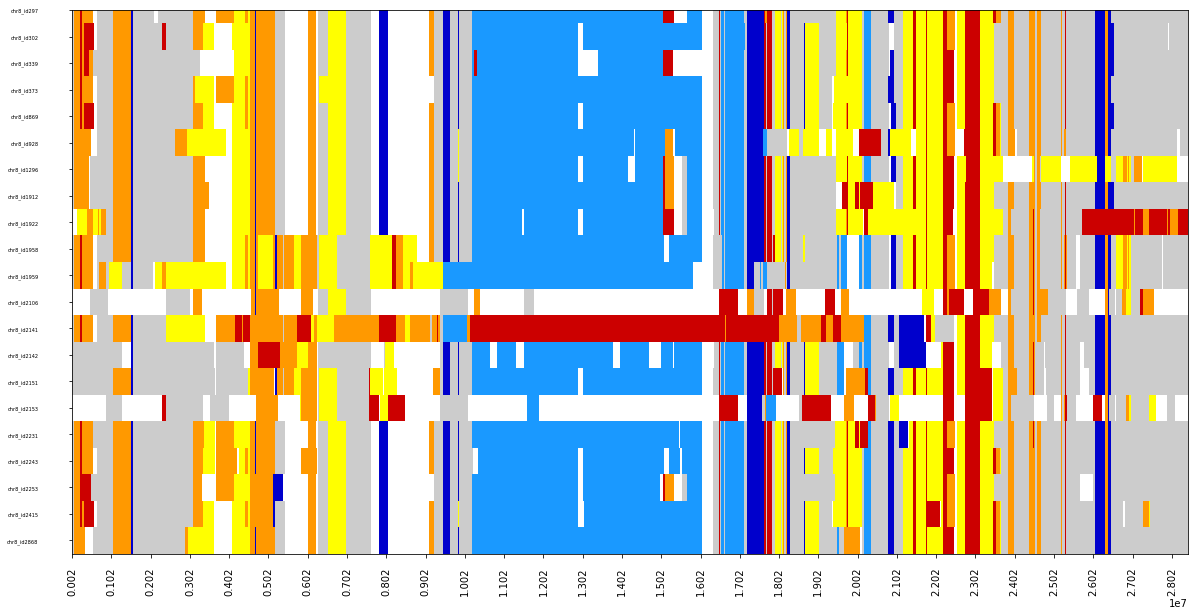

In [133]:
#from structure_tools.targeted_tools import mpl_target_ideo, chromosome_collections

select_label= [3,4,5,7,8]

Chr= 8
plot_tool= 'mpl'

plot_who= [3]

order= list(it.chain(*[ref_dict[x] for x in plot_who]))
#order= list(range(len(Nsample)))
names_sample= [Names[x] for x in Nsample]
#names_sample= [names_sample[x] for x in order]

Colors= {
    -1: [192,192,192],
    1: [139,0,0],
    3: [205,0,0],
    4: [255,255,0],
    5: [30,144,255],
    6: [0,0,255],
    7: [0,0,205],
    8: [255,165,0],
    9: [255,0,0],
    2: [0,0,0]
}

if plot_tool== 'plotly':

    Colors= {
        x: 'rgba(' + ','.join([str(z) for z in Colors[x]]) + ',1)' for x in Colors.keys()
    }

    target_ideogram(select_label,Coordinates,IDs,Colors=Colors,Chr= Chr,background= False,height_chrom= .5,height= 10,width= 5)

if plot_tool== 'mpl':
    
    background= True
    ideo_height= 1
    ideo_spacing= 0
    height= 10
    width= 20
    
    xticks= 1e6
    fig_save= True
    fig_id= 'ideo_target_gp{}'.format('.'.join([str(x) for x in plot_who]))
    Home= ''

    mpl_target_ideo(select_label,
                    Coordinates,
                    names_sample,
                    order= order,
                    background= True,
                    Chr= Chr,
                    ideo_height= ideo_height,
                    ideo_spacing= ideo_spacing,
                    xticks= xticks,
                    fig_save= fig_save,
                    fig_id= 'ideo_target',
                    Colors= Colors,
                    height= height,
                    width= width,
                   Home= Home)

